In [1]:
sc

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns
sns.set(style="whitegrid")

import fiona
import fiona.crs
import shapely
import rtree

import pandas as pd
import geopandas as gpd


In [3]:
shapefile = 'geo_export_e9d3582a-5b2b-4f57-a181-13de90251c84.shp'
comm = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2790))
comm

,perimeter,community,shape_len,shape_area,area,comarea,area_numbe,area_num_1,comarea_id,geometry
0,0.0,DOUGLAS,31027.054510,4.600462e+07,0.0,0.0,35,35,0.0,"POLYGON ((360144.2468275505 575106.3365931036,..."
1,0.0,OAKLAND,19565.506153,1.691396e+07,0.0,0.0,36,36,0.0,"POLYGON ((361581.7187503375 572034.7675512792,..."
2,0.0,FULLER PARK,25339.089750,1.991670e+07,0.0,0.0,37,37,0.0,"POLYGON ((358550.672491759 570339.1045798016, ..."
3,0.0,GRAND BOULEVARD,28196.837157,4.849250e+07,0.0,0.0,38,38,0.0,"POLYGON ((360372.4794208959 572011.601851514, ..."
4,0.0,KENWOOD,23325.167906,2.907174e+07,0.0,0.0,39,39,0.0,"POLYGON ((361581.7187503375 572034.7675512792,..."
5,0.0,LINCOLN SQUARE,36624.603085,7.135233e+07,0.0,0.0,4,4,0.0,"POLYGON ((354611.6860858612 589658.4415737576,..."
6,0.0,WASHINGTON PARK,28175.316087,4.237388e+07,0.0,0.0,40,40,0.0,"POLYGON ((360457.2770231311 568575.6723627201,..."
7,0.0,HYDE PARK,29746.708202,4.510538e+07,0.0,0.0,41,41,0.0,"POLYGON ((362574.1809296643 570443.4162790448,..."
8,0.0,WOODLAWN,46936.959244,5.781518e+07,0.0,0.0,42,42,0.0,"POLYGON ((362858.783012469 568626.6409682452, ..."
9,0.0,ROGERS PARK,34052.397576,5.125990e+07,0.0,0.0,1,1,0.0,"POLYGON ((356237.5762357235 592121.821263395, ..."


In [4]:
def createIndex(shapefile):
    import rtree
    import fiona.crs
    import geopandas as gpd
    zones = gpd.read_file(shapefile).to_crs(fiona.crs.from_epsg(2790))
    index = rtree.Rtree()
    for idx,geometry in enumerate(zones.geometry):
        index.insert(idx, geometry.bounds)
    return (index, zones)

def findZone(p, index, zones):
    match = index.intersection((p.x, p.y, p.x, p.y))
    for idx in match:
        if zones.geometry[idx].contains(p):
            return idx
    return None

def processTrips(pid, records):
    import csv
    import pyproj
    import shapely.geometry as geom
    
    proj = pyproj.Proj(init="epsg:2790", preserve_units=True)    
    index, zones = createIndex('geo_export_e9d3582a-5b2b-4f57-a181-13de90251c84.shp')    
    
    if pid==0:
        records.next()
    reader = csv.reader(records)
    counts = {}
    
    for row in reader:
#         pdt = row[0].split(' ')[1].split(':')[0]
#         if pdt!='10':
#             continue
        #print row
        try:
            p = geom.Point(proj(float(row[21]), float(row[20])))
        except:
            #print("cant convert")
            continue
        
        
        zone = findZone(p, index, zones)
        if zone:
            counts[zone] = counts.get(zone, 0) + 1
    return counts.items()
    
rdd = sc.textFile('chi100k.csv')
counts = rdd.mapPartitionsWithIndex(processTrips)
counts = counts.reduceByKey(lambda x,y: x+y)
counts = counts.collect()
len(counts)

74

C:\Users\Sunny\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


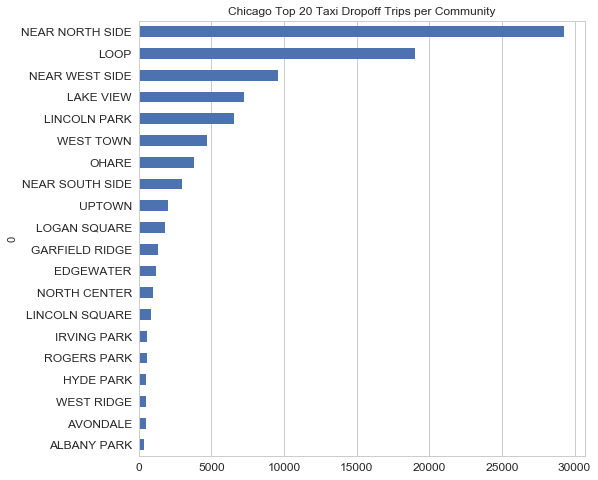

In [5]:
countsPerComm = map(lambda x: (comm['community'][x[0]], x[1]), counts)
df = pd.DataFrame(countsPerComm).sort_values(1).set_index(0)
df.tail(20).plot(kind='barh', title='Chicago Top 20 Taxi Dropoff Trips per Community', figsize=(8,8), fontsize=12, legend=False)
plt.axes().yaxis.grid(False)

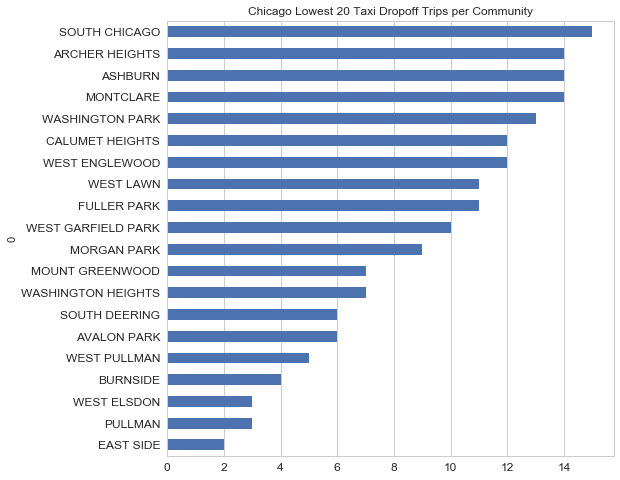

In [6]:
countsPerComm = map(lambda x: (comm['community'][x[0]], x[1]), counts)
df = pd.DataFrame(countsPerComm).sort_values(1).set_index(0)
df.head(20).plot(kind='barh', title='Chicago Lowest 20 Taxi Dropoff Trips per Community', figsize=(8,8), fontsize=12, legend=False)
plt.axes().yaxis.grid(False)

1    74
dtype: int64